# Flickr8k Dataset – Exploratory Data Analysis (EDA) and Preprocessing

This notebook performs preliminary exploratory data analysis on the [Flickr8k](https://www.kaggle.com/datasets/adityajn105/flickr8k?select=captions.txt) dataset.  
We will examine the dataset structure, caption statistics (lengths, vocabulary, frequency), and image properties (dimensions, formats).  
The goal is to understand the data and define preprocessing steps needed before training deep learning models for image captioning.

## Data Setup

To download datasets from Kaggle, you need an API key.

**Step 1.** Get your Kaggle API key
- Go to https://www.kaggle.com/account
- Click "Create New API Token"
- This downloads a file called kaggle.json

**Step 2:.** Place kaggle.json in one of these locations:
- Mac/Linux:   ~/.kaggle/kaggle.json
- Windows:     C:\Users\<you>\.kaggle\kaggle.json

**Step 3.** Run the cell below (uncomment first)
- It will install Kaggle API (if missing)
- It will download Flickr8k into the data/ folder

In [ ]:
# Install Kaggle API if not already installed
%pip install -q kaggle

# Download and unzip Flickr8k dataset into the "data/" folder
!kaggle datasets download -d adityajn105/flickr8k -p data
!unzip -q data/flickr8k.zip -d data/

# After success, you should see:
# data/
#   ├── flickr8k.zip                         (original zip file)
#   ├── captions.txt                         (captions)
#   └── Images/                              (unzipped folder containing 8091 .jpg images)

Note: you may need to restart the kernel to use updated packages.
Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
 64%|█████████████████████████              | 681M/1.04G [00:00<00:00, 7.07GB/s]
100%|██████████████████████████████████████| 1.04G/1.04G [00:00<00:00, 6.78GB/s]


## Captions File Format

The file `captions.txt` stores all image-caption pairs in a simple CSV-style format with two columns:

image,caption

1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .

1000268201_693b08cb0e.jpg,A girl going into a wooden building .

1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .

1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .

1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .

....


Each image appears 5 times, once for each caption.  
- **Column 1:** the image filename (e.g., `1000268201_693b08cb0e.jpg`)  
- **Column 2:** the corresponding natural language description.  
- Total data: **8091 unique images** and **40,455 captions** (5 captions per image).  

### Imports

In [8]:
import os        
from PIL import Image
import pandas as pd    
import numpy as np       
import matplotlib.pyplot as plt  
from collections import Counter  
import random
import re
import itertools
import json
import pathlib

In [2]:
## Install nltk if not already installed
# %pip install nltk
import nltk
## Download stopwords if not already downloaded
# nltk.download("stopwords")
from nltk.corpus import stopwords

### Sanity Checks

In [3]:
# Image and caption path

IMG_DIR = "data/Images"
CAP_PATH = "data/captions.txt"

print("Number of images in data/Images/ folder:", len([f for f in os.listdir(IMG_DIR) if f.endswith(".jpg")]))

# Load captions
captions = pd.read_csv(CAP_PATH)

num_images = captions['image'].nunique()
num_captions = len(captions)

print("Number of images in captions file:", num_images)
print("Number of captions:", num_captions)

# Sanity check: should be 5 captions per image
if num_captions == 5 * num_images:
    print("Each image has exactly 5 captions.")
else:
    print("Caption count mismatch!")
    counts = captions.groupby("image")["caption"].count()
    print(counts.value_counts())

Number of images in data/Images/ folder: 8091
Number of images in captions file: 8091
Number of captions: 40455
Each image has exactly 5 captions.


## Captions Analysis

#### Caption Length

count    40455.000000
mean        11.782598
std          3.885152
min          1.000000
25%          9.000000
50%         11.000000
75%         14.000000
max         38.000000
Name: caption_len, dtype: float64


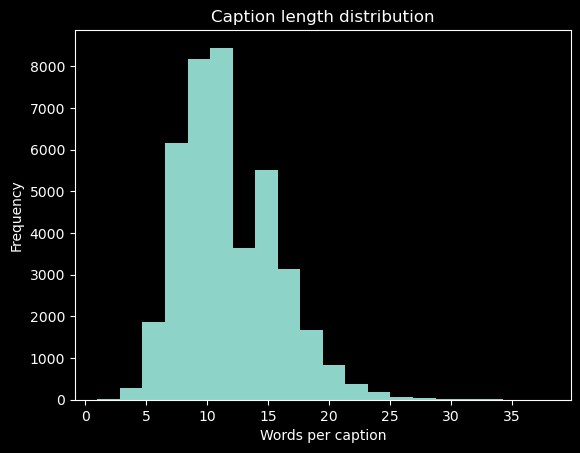

In [4]:
captions["caption_len"] = captions["caption"].str.split().apply(len)
print(captions["caption_len"].describe())

plt.hist(captions["caption_len"], bins=20)
plt.xlabel("Words per caption")
plt.ylabel("Frequency")
plt.title("Caption length distribution")
plt.show()


#### Vocabulary Size

In [5]:
# Collect all words (lowercase, space-split)
all_words = " ".join(captions["caption"].str.lower()).split()

# Count word frequencies
word_counts = Counter(all_words)

# Vocabulary size
vocab_size = len(word_counts)
print("Vocabulary size:", vocab_size)

print("\nMost common words:\n")
word_df = pd.DataFrame(word_counts.items(), columns=["word", "count"])
word_df = word_df.sort_values(by="count", ascending=False).reset_index(drop=True)
word_df.head(20)

Vocabulary size: 8918

Most common words:



,word,count
0,a,62986
1,.,36577
2,in,18974
3,the,18418
4,on,10743
5,is,9345
6,and,8851
7,dog,8136
8,with,7765
9,man,7265


#### Tokenization

The tokenize function takes as input a string, and returns a list of all words in the caption in lowercase, removing all non-alphanumeric characters like hyphen, commas, fullstops. 

In [6]:
def tokenize(text):
    # Lowercase
    text = text.lower()
    # Replace all non-alphanumeric characters (except apostrophes) with spaces
    text = re.sub(r"[^a-z0-9']+", " ", text)
    # Split on spaces
    tokens = text.strip().split()
    return tokens

# Example
tokenize("A black dog runs fast.")

['a', 'black', 'dog', 'runs', 'fast']

#### Most Frequent Bigrams and Trigrams

In [46]:
# Tokenize all captions
token_lists = captions["caption"].apply(tokenize)

# Collect bigrams & trigrams
bigrams = list(itertools.chain.from_iterable(
    zip(tokens, tokens[1:]) for tokens in token_lists
))
trigrams = list(itertools.chain.from_iterable(
    zip(tokens, tokens[1:], tokens[2:]) for tokens in token_lists
))

bigram_counts = Counter(bigrams)
trigram_counts = Counter(trigrams)

print("Most common bigrams:")
display(pd.DataFrame(bigram_counts.most_common(10), columns=["bigram","count"]))

print("\nMost common trigrams:")
display(pd.DataFrame(trigram_counts.most_common(10), columns=["trigram","count"]))

Most common bigrams:


,bigram,count
0,"(in, a)",6472
1,"(on, a)",5221
2,"(in, the)",5055
3,"(a, man)",5054
4,"(with, a)",3300
5,"(on, the)",2484
6,"(of, a)",2389
7,"(a, woman)",2193
8,"(a, black)",1994
9,"(a, dog)",1990



Most common trigrams:


,trigram,count
0,"(in, front, of)",1304
1,"(a, man, in)",1087
2,"(a, group, of)",1058
3,"(front, of, a)",876
4,"(man, in, a)",847
5,"(a, black, dog)",749
6,"(and, white, dog)",742
7,"(a, brown, dog)",741
8,"(in, the, snow)",671
9,"(in, the, air)",669


#### Caption-wise Overlap between Images

In [8]:
# Count how many unique captions appear for more than one image
dup_captions = captions.groupby("caption")["image"].nunique()
overlap = dup_captions[dup_captions > 1].sort_values(ascending=False)

print("Number of captions shared across multiple images:", len(overlap))
display(overlap.head(10))

Number of captions shared across multiple images: 187


caption
Two dogs playing in the snow .                7
A dog runs through the grass .                6
two dogs play together .                      6
A person on a bmx bike .                      6
A dog swimming with a stick in its mouth .    5
Two dogs run through a field .                5
Two dogs play in the grass .                  5
A dog catching a Frisbee .                    4
A surfer rides the waves .                    4
a dog runs across the grass .                 4
Name: image, dtype: int64

#### Stopwords/Filler Words vs Meaningful Words

Captions in the Flickr8k dataset contain a mix of stopwords and content words. On average, about 41% of words are stopwords, which are necessary for grammar but carry little semantic meaning. The remaining non-stopwords (e.g., dog, man, child, playing) capture the key objects and actions, and are most informative for modeling.

count    40455.000000
mean         0.410307
std          0.110855
min          0.000000
25%          0.333333
50%          0.428571
75%          0.500000
max          1.000000
Name: stopword_frac, dtype: float64


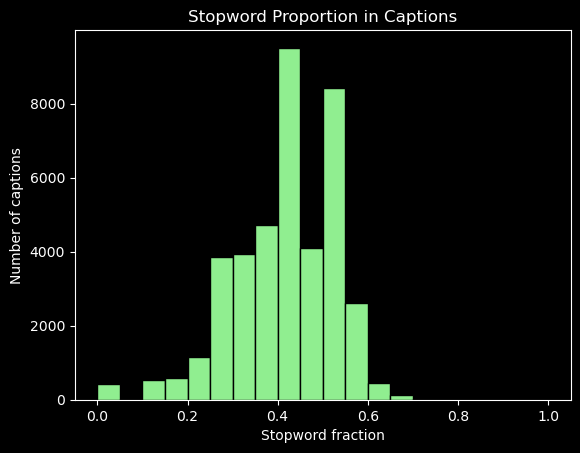

In [55]:
stop_words = set(stopwords.words("english"))

def stopword_fraction(tokens):
    if not tokens:
        return 0
    stop_count = sum(1 for w in tokens if w in stop_words)
    return stop_count / len(tokens)

# Use your tokenize() function
captions["tokens"] = captions["caption"].apply(tokenize)

# Compute stopword fraction per caption
captions["stopword_frac"] = captions["tokens"].apply(stopword_fraction)

# Summary stats
print(captions["stopword_frac"].describe())

# Plot histogram
plt.hist(captions["stopword_frac"], bins=20, color="lightgreen", edgecolor="black")
plt.xlabel("Stopword fraction")
plt.ylabel("Number of captions")
plt.title("Stopword Proportion in Captions")
plt.show()


#### Most common non-stopwords

In [56]:
# Flatten all tokens but exclude stopwords
all_tokens = [w for toks in captions["tokens"] for w in toks if w not in stop_words]

# Count frequency
word_counts = Counter(all_tokens)

nonstop_df = pd.DataFrame(word_counts.most_common(20), columns=["word", "count"])

print("Top 20 most common non-stopwords in captions:")
display(nonstop_df)

Top 20 most common non-stopwords in captions:


,word,count
0,dog,8138
1,man,7274
2,two,5642
3,white,3959
4,black,3848
5,boy,3581
6,woman,3402
7,girl,3328
8,wearing,3062
9,people,2883


#### Object Mentions in Captions

This distribution shows which objects or people are most frequently depicted in the dataset. Humans (man, boy, woman, girl, child) dominate the captions, followed by dogs, making them the most common subjects. Rare categories like cat, bus, horse appear in very few images, indicating class imbalance that could bias a model toward more frequent entities.

In [57]:
captions["tokens"] = captions["caption"].apply(tokenize)

# Define target words to check
target_words = ["dog", "dogs", "cat", "man", "woman", "girl", "boy", "child", "horse", "car", "bike", "bus"]

class_image_counts = {}

for word in target_words:
    # Images where the word appears in ANY caption
    imgs_with_word = captions[captions["tokens"].apply(lambda toks: word in toks)]["image"].unique()
    class_image_counts[word] = len(imgs_with_word)

class_dist_df = pd.DataFrame(list(class_image_counts.items()), columns=["class","num_images"])
class_dist_df = class_dist_df.sort_values(by="num_images", ascending=False).reset_index(drop=True)

print("Number of distinct images containing each class/object:")
display(class_dist_df)

Number of distinct images containing each class/object:


,class,num_images
0,man,2470
1,dog,1814
2,boy,1269
3,woman,1247
4,girl,1165
5,child,874
6,dogs,605
7,bike,371
8,car,154
9,horse,66


## Image Analysis

In [7]:
# Image Format 
image_files = [f for f in os.listdir(IMG_DIR) if f.lower().endswith(".jpg")]

# Quick check for file extensions (only .jpg expected)
extensions = set([os.path.splitext(f)[1].lower() for f in image_files])
print("File extensions found:", extensions)

File extensions found: {'.jpg'}


#### Image Dimensions and Aspect Ratio Distribution

We check if images come in very different sizes or shapes to understand whether resizing or padding is needed before training. This ensures all images are consistent and won’t distort when fed into the model.

Total images processed: 8091
Median (W,H): [500. 375.]
Min: [164 127] Max: [500 500]


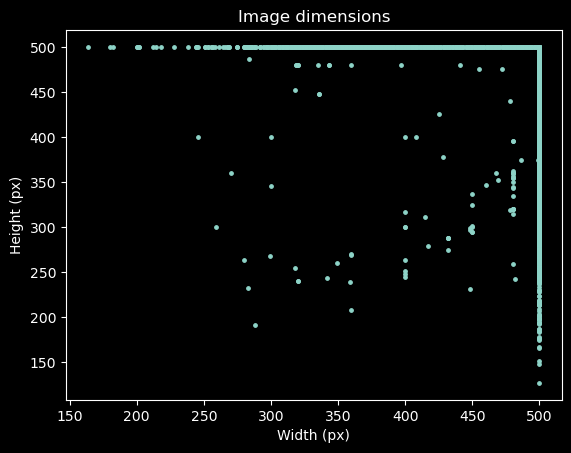

In [11]:
dims = []
for fname in image_files:
    path = os.path.join(IMG_DIR, fname)
    try:
        with Image.open(path) as img:
            dims.append(img.size)  # (width, height)
    except:
        print("Corrupt image:", fname)

dims = np.array(dims)
from statistics import mode

print("Total images processed:", len(dims))
print("Median (W,H):", np.median(dims, axis=0))
print("Min:", dims.min(axis=0), "Max:", dims.max(axis=0))

# Image Size Distribution
plt.scatter(dims[:,0], dims[:,1], s=6)
plt.xlabel("Width (px)")
plt.ylabel("Height (px)")
plt.title("Image dimensions")
plt.show()


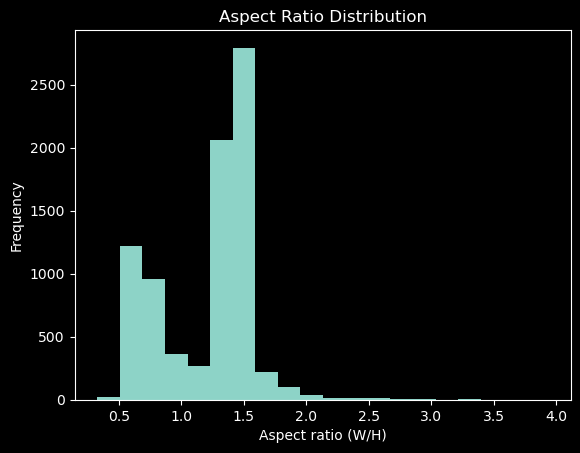

In [60]:
aspect_ratios = [w/h for (w,h) in dims] 
plt.hist(aspect_ratios, bins=20)
plt.xlabel("Aspect ratio (W/H)")
plt.ylabel("Frequency")
plt.title("Aspect Ratio Distribution")
plt.show()

#### Some examples of images with thier captions

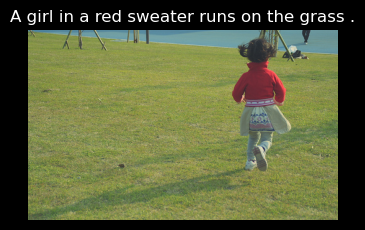

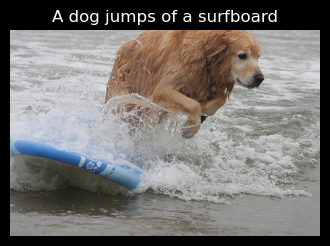

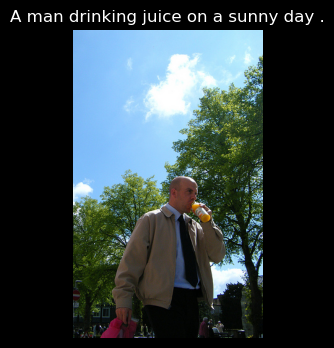

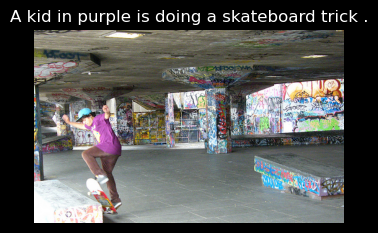

In [ ]:
grouped = captions.groupby("image")["caption"].apply(list)
sample_imgs = random.sample(list(grouped.index), 4)

for img in sample_imgs:
    path = os.path.join(IMG_DIR, img)
    with Image.open(path) as im:
        plt.figure(figsize=(4,4))
        plt.imshow(im)
        plt.axis("off")
        plt.title(grouped[img][0])  # show first caption
        plt.show()


## Data Preprocessing Outline

#### 1. Dataset integrity & splits (by image)
- Verify: 8,091 JPGs; 40,455 captions (≈5 per image); no missing/corrupt files.
- Split **by image** to prevent caption leakage:
  - Train 70% | Validation 15% | Test 15%.
- Save artifacts:
  - `data/splits/train_images.txt`
  - `data/splits/val_images.txt`
  - `data/splits/test_images.txt`


#### 2. Caption text processing
- Clean/tokenize: lowercase, remove punctuation, keep stopwords for grammar.
- Add special tokens:
  - `<start>` and `<end>` to mark caption boundaries.
  - `<pad>` for batching (loss will ignore pad positions).
  - `<unk>` for rare words (frequency < 5).
- Build vocabulary: keep words with frequency ≥ 5.
- Convert captions to ID sequences.
- Save artifacts:
  - `data/processed/vocab.json` (token → id)
  - `data/processed/idx2word.json` (id → token)
  - `data/processed/{train,val,test}_captions.jsonl`  
    Example entry:  
    `{"image": "1000268201_693b08cb0e.jpg", "ids": [<start>, 42, 313, …, <end>]}`

#### 3. Image preprocessing
- Resize all images to the size expected by the encoder backbone (e.g., 224×224 for ResNet).
- Color mode: ensure RGB.
- Normalization: apply ImageNet mean/std during training.
- Save resized copies:
  - `data/processed/resized_images/{train,val,test}/...`
- On-the-fly transforms for training only: random crop, horizontal flip, light color jitter.

#### 4. Class imbalance considerations
EDA shows a strong skew toward humans and dogs. To address this later:
- Use balanced sampling by caption keywords (dog, man, cat, etc.).
- Apply augmentation to underrepresented categories.
- Report per-category metrics to ensure performance isn’t driven only by frequent classes.


## Preprocessing

#### Setup

In [11]:
IMG_DIR = "data/Images"
CAP_PATH = "data/captions.txt"
SPLIT_DIR = "data/splits"
PROC_DIR  = "data/processed"

os.makedirs(SPLIT_DIR, exist_ok=True)
os.makedirs(PROC_DIR, exist_ok=True)

#### Train/Test/Validation Split

In [13]:
captions = pd.read_csv(CAP_PATH)

# Integrity checks
n_imgs_fs = len([f for f in os.listdir(IMG_DIR) if f.lower().endswith(".jpg")])
n_imgs_in_caps = captions["image"].nunique()
n_pairs = len(captions)

print("Filesystem images:", n_imgs_fs)
print("Images referenced:", n_imgs_in_caps)
print("Caption pairs:", n_pairs)
assert n_imgs_fs == n_imgs_in_caps, "Mismatch: images on disk vs in captions"
assert n_pairs == 5 * n_imgs_in_caps, "Each image should have 5 captions"

# Reproducible split by image (70/15/15)
random.seed(42)
images = sorted(captions["image"].unique().tolist())
random.shuffle(images)

n = len(images)
n_train = int(0.70 * n)
n_val   = int(0.15 * n)

train_imgs = images[:n_train]
val_imgs   = images[n_train:n_train+n_val]
test_imgs  = images[n_train+n_val:]

# Save split files (one filename per line) using string paths
with open(os.path.join(SPLIT_DIR, "train_images.txt"), "w") as f:
    f.write("\n".join(train_imgs))
with open(os.path.join(SPLIT_DIR, "val_images.txt"), "w") as f:
    f.write("\n".join(val_imgs))
with open(os.path.join(SPLIT_DIR, "test_images.txt"), "w") as f:
    f.write("\n".join(test_imgs))

print("Saved splits:", len(train_imgs), len(val_imgs), len(test_imgs))


Filesystem images: 8091
Images referenced: 8091
Caption pairs: 40455
Saved splits: 5663 1213 1215


#### Caption Text Preprocessing

In [14]:
# Special tokens
PAD, START, END, UNK = "<pad>", "<start>", "<end>", "<unk>"
MIN_FREQ = 5

# Tokenize all captions
captions["tokens"] = captions["caption"].apply(tokenize)

# Build frequency table (keep stopwords for grammar)
freq = Counter([w for toks in captions["tokens"] for w in toks])

# Build vocab with min frequency
vocab_words = sorted([w for w, c in freq.items() if c >= MIN_FREQ])

# token -> id (pad must be 0)
word2idx = {PAD: 0, START: 1, END: 2, UNK: 3}
for w in vocab_words:
    if w not in word2idx:
        word2idx[w] = len(word2idx)

idx2word = {i: w for w, i in word2idx.items()}

# Save vocab
with open(os.path.join(PROC_DIR, "vocab.json"), "w") as f:
    json.dump(word2idx, f)
with open(os.path.join(PROC_DIR, "idx2word.json"), "w") as f:
    json.dump(idx2word, f)

print("Vocab size (incl specials):", len(word2idx))

# Convert a caption to ID sequence with <start>/<end>/<unk>
def to_ids(tokens):
    return [word2idx[START]] + [word2idx.get(t, word2idx[UNK]) for t in tokens] + [word2idx[END]]

# Group captions by image
caps_by_img = captions.groupby("image")["tokens"].apply(list).to_dict()

# Write JSONL for each split
def write_jsonl(img_list, out_path):
    with open(out_path, "w") as f:
        for img in img_list:
            for toks in caps_by_img.get(img, []):
                ex = {"image": img, "ids": to_ids(toks)}
                f.write(json.dumps(ex) + "\n")

write_jsonl(train_imgs, os.path.join(PROC_DIR, "train_captions.jsonl"))
write_jsonl(val_imgs,   os.path.join(PROC_DIR, "val_captions.jsonl"))
write_jsonl(test_imgs,  os.path.join(PROC_DIR, "test_captions.jsonl"))

print("Saved JSONL caption files in:", PROC_DIR)


Vocab size (incl specials): 2982
Saved JSONL caption files in: data/processed


#### Image Resizing

In [15]:
TARGET_SIZE = (224, 224)

def resize_split(split_name, img_names):
    out_dir = os.path.join(PROC_DIR, "resized_images", split_name)
    os.makedirs(out_dir, exist_ok=True)
    done = 0
    for fn in img_names:
        src = os.path.join(IMG_DIR, fn)
        dst = os.path.join(out_dir, fn)
        if os.path.exists(dst):
            done += 1
            continue
        with Image.open(src) as im:
            im = im.convert("RGB")
            im = im.resize(TARGET_SIZE)
            im.save(dst, format="JPEG", quality=95)
            done += 1
        if done % 500 == 0:
            print(f"{split_name}: {done}/{len(img_names)}")
    print(f"{split_name}: {done}/{len(img_names)} (done) → {out_dir}")

resize_split("train", train_imgs)
resize_split("val",   val_imgs)
resize_split("test",  test_imgs)

train: 500/5663
train: 1000/5663
train: 1500/5663
train: 2000/5663
train: 2500/5663
train: 3000/5663
train: 3500/5663
train: 4000/5663
train: 4500/5663
train: 5000/5663
train: 5500/5663
train: 5663/5663 (done) → data/processed/resized_images/train
val: 500/1213
val: 1000/1213
val: 1213/1213 (done) → data/processed/resized_images/val
test: 500/1215
test: 1000/1215
test: 1215/1215 (done) → data/processed/resized_images/test


## Summary of Preprocessed Data

In [16]:
summary = {
    "images": {
        "total": len(images),
        "train": len(train_imgs),
        "val": len(val_imgs),
        "test": len(test_imgs),
    },
    "captions": {
        "pairs_total": len(captions),
        "per_image_expected": 5
    },
    "vocab": {
        "size_including_specials": len(word2idx),
        "min_freq": MIN_FREQ,
        "special_tokens": [PAD, START, END, UNK]
    },
    "artifacts": {
        "splits_dir": SPLIT_DIR,
        "vocab": os.path.join(PROC_DIR, "vocab.json"),
        "idx2word": os.path.join(PROC_DIR, "idx2word.json"),
        "train_jsonl": os.path.join(PROC_DIR, "train_captions.jsonl"),
        "val_jsonl": os.path.join(PROC_DIR, "val_captions.jsonl"),
        "test_jsonl": os.path.join(PROC_DIR, "test_captions.jsonl"),
        "resized_images": os.path.join(PROC_DIR, "resized_images")
    }
}

summary

{'images': {'total': 8091, 'train': 5663, 'val': 1213, 'test': 1215},
 'captions': {'pairs_total': 40455, 'per_image_expected': 5},
 'vocab': {'size_including_specials': 2982,
  'min_freq': 5,
  'special_tokens': ['<pad>', '<start>', '<end>', '<unk>']},
 'artifacts': {'splits_dir': 'data/splits',
  'vocab': 'data/processed/vocab.json',
  'idx2word': 'data/processed/idx2word.json',
  'train_jsonl': 'data/processed/train_captions.jsonl',
  'val_jsonl': 'data/processed/val_captions.jsonl',
  'test_jsonl': 'data/processed/test_captions.jsonl',
  'resized_images': 'data/processed/resized_images'}}